# Import Library

In [1]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import os
from os import listdir
import os.path as op
from glob import glob
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import  train_test_split, KFold

In [3]:
import torch

from torchvision import datasets , models , transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, SubsetRandomSampler

import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# Load data

In [4]:
!git clone https://github.com/seensiravit/Parkinson-Early-Detection.git

Cloning into 'Parkinson-Early-Detection'...
remote: Enumerating objects: 1449, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 1449 (delta 3), reused 77 (delta 1), pack-reused 1368
Receiving objects: 100% (1449/1449), 161.96 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (1207/1207), done.
Error downloading object: model/model_vgg16.pth (70a0f05): Smudge error: Error downloading model/model_vgg16.pth (70a0f0599bb024c676b7290a929f5b2158861ad3cf5eb814c12da318e1bf2272): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/Parkinson-Early-Detection/.git/lfs/logs/20240611T150014.075303628.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: model/model_vgg16.pth: smudge filter lfs failed
You can inspect what was checke

## train set

In [32]:
input_train_root = 'Parkinson-Early-Detection/dataset/Data/train'

input_train_healthy_root, input_train_patient_root = glob(f"{input_train_root}/*")

if 'Patient' in input_train_healthy_root : input_train_healthy_root, input_train_patient_root = input_train_patient_root, input_train_healthy_root

print(f"input_train_root : {input_train_root}")
print(f"input_train_healthy_root : {input_train_healthy_root}")
print(f"input_train_patient_root : {input_train_patient_root}")

input_train_root : Parkinson-Early-Detection/dataset/Data/train
input_train_healthy_root : Parkinson-Early-Detection/dataset/Data/train/Healthy
input_train_patient_root : Parkinson-Early-Detection/dataset/Data/train/Patient


In [33]:
input_train_healthy_path = glob(f"{input_train_healthy_root}/*.jpg")
input_train_patient_path = glob(f"{input_train_patient_root}/*.jpg")

print(f"number of test_healthy: {len(input_train_healthy_path)}")
print(f"number of test_patient: {len(input_train_patient_path)}")

number of test_healthy: 180
number of test_patient: 165


In [34]:
data_train_root = 'train/'

In [35]:
# train healthy
data_train_healthy_root = f"{data_train_root}/Healthy"
if not op.exists(data_train_healthy_root) : os.makedirs(data_train_healthy_root)

for path in input_train_healthy_path :
  shutil.copy(path , op.join(data_train_healthy_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_train_healthy_root)))

180


In [36]:
# train patient
data_train_patient_root = f"{data_train_root}/Patient"
if not op.exists(data_train_patient_root) : os.makedirs(data_train_patient_root)

for path in input_train_patient_path :
  shutil.copy(path , op.join(data_train_patient_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_train_patient_root)))

165


## test set

In [5]:
input_test_root = 'Parkinson-Early-Detection/dataset/Data/test'

input_test_healthy_root, input_test_patient_root = glob(f"{input_test_root}/*")

if 'Patient' in input_test_healthy_root : input_test_healthy_root, input_test_patient_root = input_test_patient_root, input_test_healthy_root

print(f"input_test_root : {input_test_root}")
print(f"input_test_healthy_root : {input_test_healthy_root}")
print(f"input_test_patient_root : {input_test_patient_root}")

input_test_root : Parkinson-Early-Detection/dataset/Data/test
input_test_healthy_root : Parkinson-Early-Detection/dataset/Data/test/Healthy
input_test_patient_root : Parkinson-Early-Detection/dataset/Data/test/Patient


In [6]:
input_test_healthy_path = glob(f"{input_test_healthy_root}/*.jpg")
input_test_patient_path = glob(f"{input_test_patient_root}/*.jpg")

print(f"number of test_healthy: {len(input_test_healthy_path)}")
print(f"number of test_patient: {len(input_test_patient_path)}")

number of test_healthy: 10
number of test_patient: 10


In [7]:
data_test_root = 'test'

In [8]:
# test healthy
data_test_healthy_root = f"{data_test_root}/Healthy"
if not op.exists(data_test_healthy_root) : os.makedirs(data_test_healthy_root)

for path in input_test_healthy_path :
  shutil.copy(path , op.join(data_test_healthy_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_test_healthy_root)))

10


In [9]:
# test patient
data_test_patient_root = f"{data_test_root}/Patient"
if not op.exists(data_test_patient_root) : os.makedirs(data_test_patient_root)

for path in input_test_patient_path :
  shutil.copy(path , op.join(data_test_patient_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_test_patient_root)))

10


## custom test set

In [ ]:
input_custom_root = 'Parkinson-Early-Detection/dataset/my testset'

input_custom_healthy_root, input_custom_patient_root = glob(f"{input_custom_root}/*")

if 'Patient' in input_custom_healthy_root : input_custom_healthy_root, input_custom_patient_root = input_custom_patient_root, input_custom_healthy_root

print(f"input_custom_root : {input_custom_root}")
print(f"input_custom_healthy_root : {input_custom_healthy_root}")
print(f"input_custom_patient_root : {input_custom_patient_root}")

input_custom_root : Parkinson-Early-Detection/dataset/my testset
input_custom_healthy_root : Parkinson-Early-Detection/dataset/my testset/Healthy
input_custom_patient_root : Parkinson-Early-Detection/dataset/my testset/Patient


In [ ]:
input_custom_healthy_path = glob(f"{input_custom_healthy_root}/*.jpg")
input_custom_patient_path = glob(f"{input_custom_patient_root}/*.jpg")

print(f"number of custom_healthy: {len(input_custom_healthy_path)}")
print(f"number of custom_patient: {len(input_custom_patient_path)}")

number of custom_healthy: 20
number of custom_patient: 1


In [ ]:
data_custom_root = 'custom'

In [ ]:
# custom healthy
data_custom_healthy_root = f"{data_custom_root}/Healthy"
if not op.exists(data_custom_healthy_root) : os.makedirs(data_custom_healthy_root)

for path in input_custom_healthy_path :
  shutil.copy(path , op.join(data_custom_healthy_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_custom_healthy_root)))

20


In [ ]:
# custom patient
data_custom_patient_root = f"{data_custom_root}/Patient"
if not op.exists(data_custom_patient_root) : os.makedirs(data_custom_patient_root)

for path in input_custom_patient_path :
  shutil.copy(path , op.join(data_custom_patient_root , f"{op.basename(path)}.jpg"))

print(len(listdir(data_custom_patient_root)))

1


## electronic drawing of testset

In [ ]:
os.makedirs('elec/')

In [ ]:
os.makedirs('elec/Healthy')
os.makedirs('elec/Patient')

In [ ]:
print(f"healthy: {len(listdir('elec/Healthy'))}")
print(f"patient: {len(listdir('elec/Patient'))}")

healthy: 10
patient: 10


## resolution drawing of testset

In [ ]:
os.makedirs('resolution/')

In [ ]:
os.makedirs('resolution/Healthy')
os.makedirs('resolution/Patient')

In [ ]:
print(f"healthy: {len(listdir('resolution/Healthy'))}")
print(f"patient: {len(listdir('resolution/Patient'))}")

healthy: 10
patient: 10


## resolution custom

In [ ]:
os.makedirs('resolution2/')

In [ ]:
os.makedirs('resolution2/Healthy')
os.makedirs('resolution2/Patient')

In [ ]:
print(f"healthy: {len(listdir('resolution2/Healthy'))}")
print(f"patient: {len(listdir('resolution2/Patient'))}")

healthy: 20
patient: 1


# Transform and Dataset

In [10]:
transform = T.Compose([
    T.Resize((224 , 224)) ,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [37]:
train_data = datasets.ImageFolder("train/" , transform=transform)
train_loader = DataLoader(train_data , batch_size=32 , shuffle = False)
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 345
    Root location: train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [11]:
test_data = datasets.ImageFolder("test/" , transform=transform)
test_loader = DataLoader(test_data , batch_size=32 , shuffle = False)
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 20
    Root location: test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
custom_data = datasets.ImageFolder("custom/" , transform=transform)
custom_loader = DataLoader(custom_data , batch_size=32 , shuffle = False)
custom_loader.dataset

Dataset ImageFolder
    Number of datapoints: 21
    Root location: custom/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
elec_data = datasets.ImageFolder("elec/" , transform=transform)
elec_loader = DataLoader(elec_data , batch_size=32 , shuffle = False)
elec_loader.dataset

Dataset ImageFolder
    Number of datapoints: 20
    Root location: elec/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
resolution_data = datasets.ImageFolder("resolution/" , transform=transform)
resolution_loader = DataLoader(resolution_data , batch_size=32 , shuffle = False)
resolution_loader.dataset

Dataset ImageFolder
    Number of datapoints: 20
    Root location: resolution/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
resolution2_data = datasets.ImageFolder("resolution2/" , transform=transform)
resolution2_loader = DataLoader(resolution2_data , batch_size=32 , shuffle = False)
resolution2_loader.dataset

Dataset ImageFolder
    Number of datapoints: 21
    Root location: resolution2/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

# Load Model

In [12]:
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34.fc = nn.Linear(in_features=512, out_features=2)
model_resnet34.load_state_dict(torch.load('/content/drive/MyDrive/Coding/AI/AI_Builder/project/model/version: k-fold/model_resnet34.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


<All keys matched successfully>

In [13]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(in_features=2048, out_features=2)
model_resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Coding/AI/AI_Builder/project/model/version: k-fold/model_resnet50.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


<All keys matched successfully>

In [14]:
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier = nn.Linear(in_features=1024, out_features=2)
model_densenet121.load_state_dict(torch.load('/content/drive/MyDrive/Coding/AI/AI_Builder/project/model/version: k-fold/model_densenet121.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]


<All keys matched successfully>

In [15]:
model_densenet201 = models.densenet201(pretrained=True)
model_densenet201.classifier = nn.Linear(in_features=1920 , out_features=2)
model_densenet201.load_state_dict(torch.load('/content/drive/MyDrive/Coding/AI/AI_Builder/project/model/version: k-fold/model_densenet201.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 152MB/s]


<All keys matched successfully>

In [16]:
model_vgg16 = models.vgg16(pretrained = True)
model_vgg16.classifier[6] = nn.Linear(4096, 2)
model_vgg16.load_state_dict(torch.load('/content/drive/MyDrive/Coding/AI/AI_Builder/project/model/version: k-fold/model_vgg16.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s] 


<All keys matched successfully>

# Function

In [17]:
def predict(model , loader) :
  gpu = torch.cuda.is_available()
  print(gpu)

  if gpu : model.cuda()

  y_pred , y_true  = [] , []

  model.eval()

  for images , labels in tqdm(loader) :
    if gpu :
      images , labels = images.cuda() , labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)

  print(classification_report(y_true, y_pred))

  return y_true , y_pred

In [18]:
def display_confusionMatrix(y_true, y_pred) :
  matrix = metrics.confusion_matrix(y_true, y_pred)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Healthy', 'Patient'])

  cm_display.plot()
  plt.show()

In [19]:
def tensor_to_numpy(tensor_image) :
  tensor_image_cpu = tensor_image.cpu()
  numpy_image = tensor_image_cpu.permute(1,2,0).numpy()
  return numpy_image

In [20]:
give_class = lambda is_PD : "PD" if is_PD else "H"

In [21]:
def display_wrong_output(model, loader) :
  gpu = torch.cuda.is_available()
  print(gpu)

  if gpu : model.cuda()

  model.eval()

  y_true = []
  y_pred = []

  false_images = []
  false_outputs = []

  for images , labels in tqdm(loader) :
    if gpu :
      images , labels = images.cuda() , labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
    for i in range(len(labels)) :
      if not yt[i] == yp[i] :
        # plt.imshow(images[i])
        # print(images[i])
        false_images.append(images[i])
        false_outputs.append([yt[i] , yp[i]])

  # print(false_images)
  print(classification_report(y_true , y_pred))

  plt.figure(figsize=(15,9))


  for i in range(len(false_outputs)) :
    actual, predicted = false_outputs[i]
    tensor_image = false_images[i]
    plt.subplot(1,len(false_outputs),i+1)
    plt.imshow(tensor_to_numpy(tensor_image))
    plt.title(f"{give_class(actual)} -> {give_class(predicted)}")
    plt.axis('off')

# Process

## train

### resnet34

In [38]:
y_true, y_pred = predict(model_resnet34 , train_loader)

True


  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       165

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345



In [39]:
resnet34_train = accuracy_score(y_true, y_pred)
resnet34_train

1.0

### resnet50

In [40]:
y_true, y_pred = predict(model_resnet50 , train_loader)

True


  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       165

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345



In [41]:
resnet50_train = accuracy_score(y_true, y_pred)
resnet50_train

1.0

### densenet121

In [42]:
y_true, y_pred = predict(model_densenet121 , train_loader)

True


  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       165

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345



In [43]:
densenet121_train = accuracy_score(y_true, y_pred)
densenet121_train

1.0

### densenet201

In [44]:
y_true, y_pred = predict(model_densenet201 , train_loader)

True


  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       165

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345



In [45]:
densenet201_train = accuracy_score(y_true, y_pred)
densenet201_train

1.0

### vgg16

In [46]:
y_true, y_pred = predict(model_vgg16 , train_loader)

True


  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       165

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345



In [47]:
vgg16_train = accuracy_score(y_true, y_pred)
vgg16_train

1.0

## test

### resnet34

In [22]:
y_true, y_pred = predict(model_resnet34 , test_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [23]:
resnet34_test = accuracy_score(y_true, y_pred)
resnet34_test

0.9

### resnet50

In [24]:
y_true, y_pred = predict(model_resnet50 , test_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [25]:
resnet50_test = accuracy_score(y_true, y_pred)
resnet50_test

0.95

### densenet121

In [26]:
y_true, y_pred = predict(model_densenet121 , test_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [27]:
densenet121_test = accuracy_score(y_true, y_pred)
densenet121_test

0.95

### densenet201

In [28]:
y_true, y_pred = predict(model_densenet201 , test_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [29]:
densenet201_test = accuracy_score(y_true, y_pred)
densenet201_test

1.0

### vgg16

In [30]:
y_true, y_pred = predict(model_vgg16 , test_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



In [31]:
vgg16_test = accuracy_score(y_true, y_pred)
vgg16_test

0.9

## custom

### resnet34

In [ ]:
y_true, y_pred = predict(model_resnet34 , custom_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.05      1.00      0.09         1

    accuracy                           0.05        21
   macro avg       0.02      0.50      0.05        21
weighted avg       0.00      0.05      0.00        21



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
resnet34_custom = accuracy_score(y_true, y_pred)
resnet34_custom

0.047619047619047616

### resnet50

In [ ]:
y_true, y_pred = predict(model_resnet50 , custom_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.15      0.26        20
           1       0.06      1.00      0.11         1

    accuracy                           0.19        21
   macro avg       0.53      0.57      0.18        21
weighted avg       0.96      0.19      0.25        21



In [ ]:
resnet50_custom = accuracy_score(y_true, y_pred)
resnet50_custom

0.19047619047619047

### densenet121

In [ ]:
y_true, y_pred = predict(model_densenet121 , custom_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        20
           1       0.05      1.00      0.10         1

    accuracy                           0.14        21
   macro avg       0.53      0.55      0.14        21
weighted avg       0.95      0.14      0.18        21



In [ ]:
densenet121_custom = accuracy_score(y_true, y_pred)
densenet121_custom

0.14285714285714285

### densenet201

In [ ]:
y_true, y_pred = predict(model_densenet201 , custom_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        20
           1       0.06      1.00      0.11         1

    accuracy                           0.24        21
   macro avg       0.53      0.60      0.22        21
weighted avg       0.96      0.24      0.32        21



In [ ]:
densenet201_custom = accuracy_score(y_true, y_pred)
densenet201_custom

0.23809523809523808

### vgg16

In [ ]:
y_true, y_pred = predict(model_vgg16 , custom_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.20      1.00      0.33         1

    accuracy                           0.81        21
   macro avg       0.60      0.90      0.61        21
weighted avg       0.96      0.81      0.86        21



In [ ]:
vgg16_custom = accuracy_score(y_true, y_pred)
vgg16_custom

0.8095238095238095

## elec

### resnet34

In [ ]:
y_true, y_pred = predict(model_resnet34 , elec_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
resnet34_elec = accuracy_score(y_true, y_pred)
resnet34_elec

0.5

### resnet50

In [ ]:
y_true, y_pred = predict(model_resnet50 , elec_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
resnet50_elec = accuracy_score(y_true, y_pred)
resnet50_elec

0.5

### densenet121

In [ ]:
y_true, y_pred = predict(model_densenet121 , elec_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
densenet121_elec = accuracy_score(y_true, y_pred)
densenet121_elec

0.5

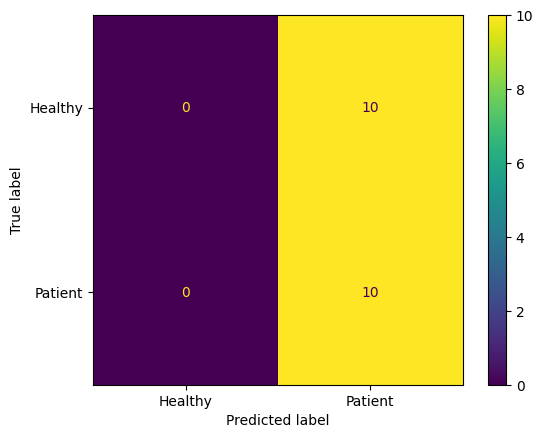

In [ ]:
display_confusionMatrix(y_true,y_pred)

### densenet201

In [ ]:
y_true, y_pred = predict(model_densenet201 , elec_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
densenet201_elec = accuracy_score(y_true, y_pred)
densenet201_elec

0.5

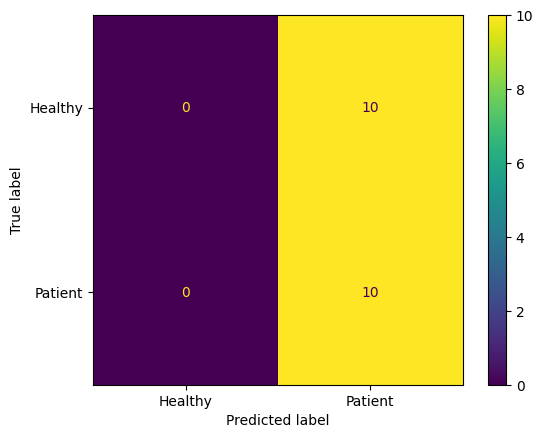

In [ ]:
display_confusionMatrix(y_true,y_pred)

### vgg16

In [ ]:
y_true, y_pred = predict(model_vgg16 , elec_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
vgg16_elec = accuracy_score(y_true, y_pred)
vgg16_elec

0.5

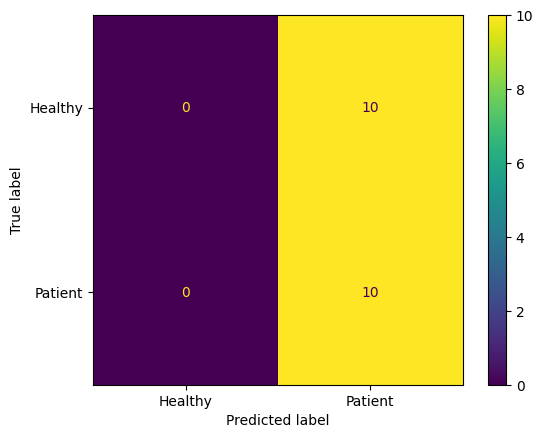

In [ ]:
display_confusionMatrix(y_true,y_pred)

## resolution

### resnet34

In [ ]:
y_true, y_pred = predict(model_resnet34 , resolution_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.53      0.80      0.64        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20



In [ ]:
resnet34_resolution = accuracy_score(y_true, y_pred)
resnet34_resolution

0.55

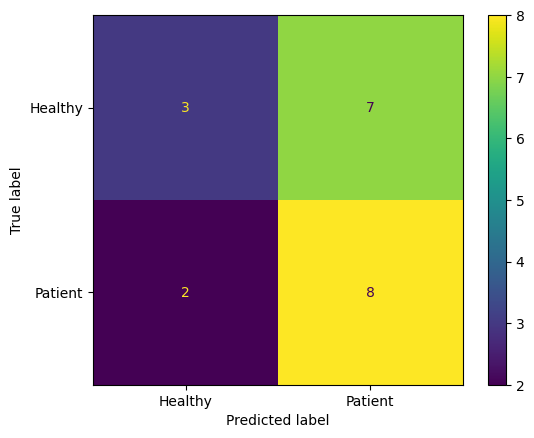

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.53      0.80      0.64        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20



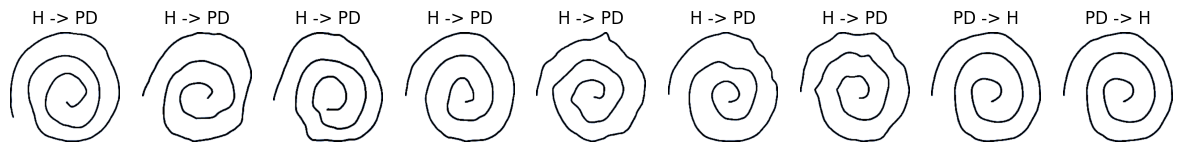

In [ ]:
display_wrong_output(model_resnet34, resolution_loader)

### resnet50

In [ ]:
y_true, y_pred = predict(model_resnet50 , resolution_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



In [ ]:
resnet50_resolution = accuracy_score(y_true, y_pred)
resnet50_resolution

0.55

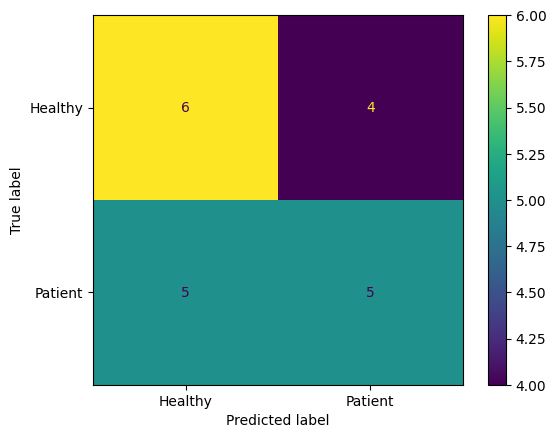

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



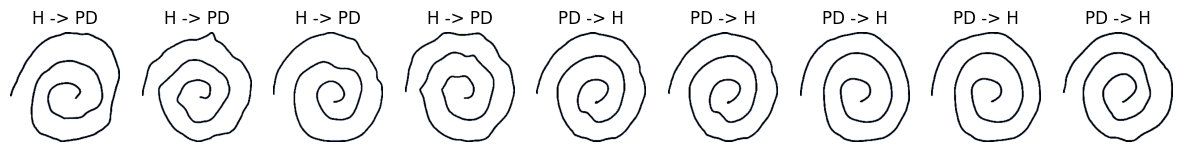

In [ ]:
display_wrong_output(model_resnet50, resolution_loader)

### densenet121

In [ ]:
y_true, y_pred = predict(model_densenet121 , resolution_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



In [ ]:
densenet121_resolution = accuracy_score(y_true, y_pred)
densenet121_resolution

0.55

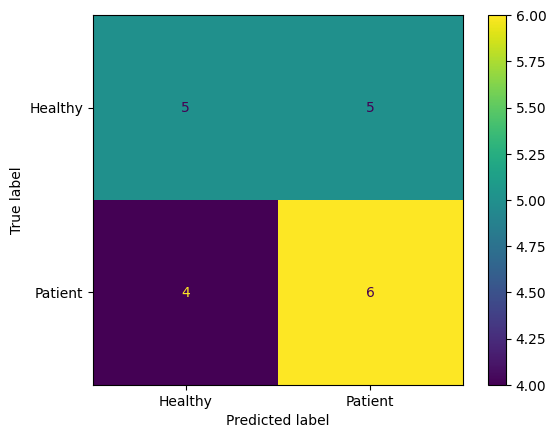

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



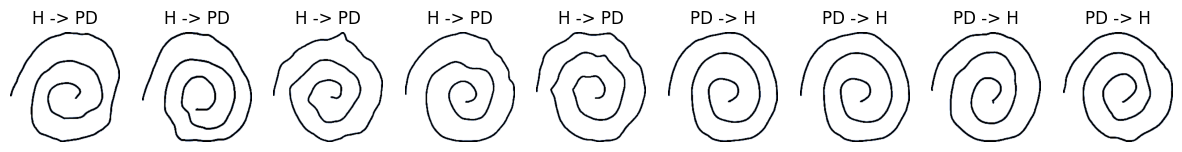

In [ ]:
display_wrong_output(model_densenet121, resolution_loader)

### densenet201

In [ ]:
y_true, y_pred = predict(model_densenet201 , resolution_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.50      0.50      0.50        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.50      0.50      0.50        20



In [ ]:
densenet201_resolution = accuracy_score(y_true, y_pred)
densenet201_resolution

0.5

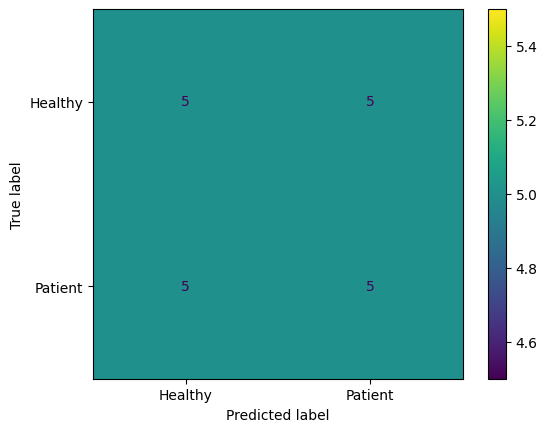

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.50      0.50      0.50        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.50      0.50      0.50        20



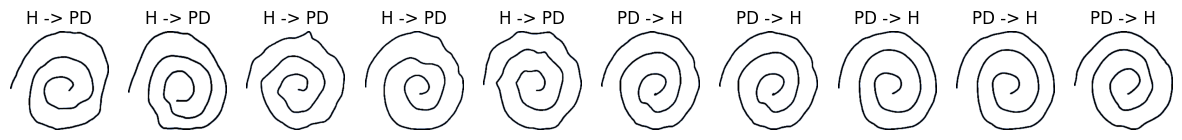

In [ ]:
display_wrong_output(model_densenet201, resolution_loader)

### vgg16

In [ ]:
y_true, y_pred = predict(model_vgg16 , resolution_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



In [ ]:
vgg16_resolution = accuracy_score(y_true, y_pred)
vgg16_resolution

0.55

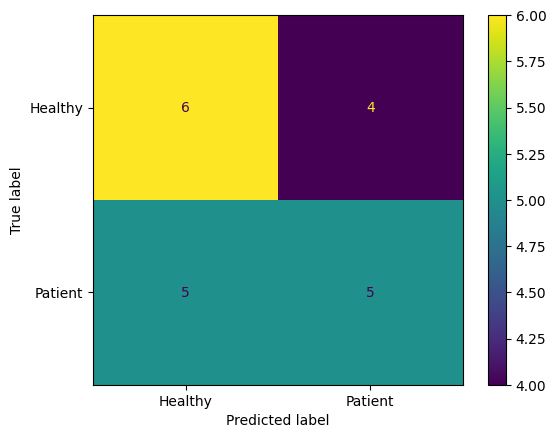

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



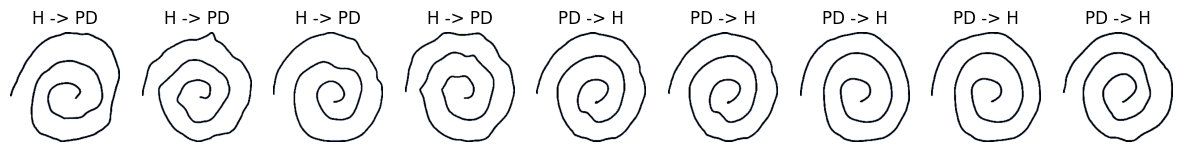

In [ ]:
display_wrong_output(model_vgg16 , resolution_loader)

## resolution2

### resnet34

In [ ]:
y_true, y_pred = predict(model_resnet34 , resolution2_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.14      1.00      0.25         1

    accuracy                           0.71        21
   macro avg       0.57      0.85      0.54        21
weighted avg       0.96      0.71      0.80        21



In [ ]:
resnet34_resolution2 = accuracy_score(y_true, y_pred)
resnet34_resolution2

0.7142857142857143

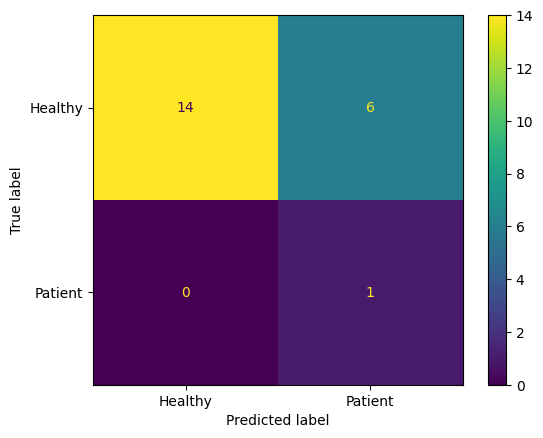

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.14      1.00      0.25         1

    accuracy                           0.71        21
   macro avg       0.57      0.85      0.54        21
weighted avg       0.96      0.71      0.80        21



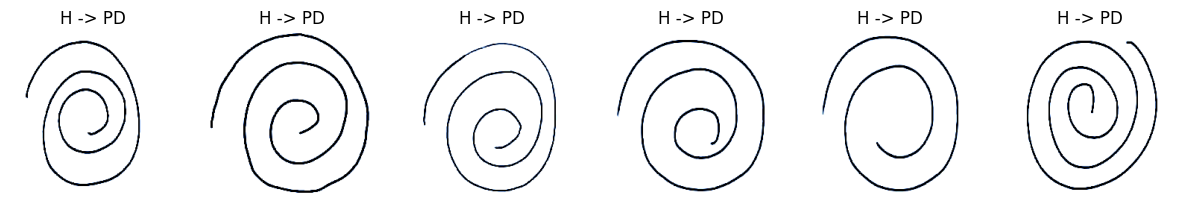

In [ ]:
display_wrong_output(model_resnet34, resolution2_loader)

### resnet50

In [ ]:
y_true, y_pred = predict(model_resnet50 , resolution2_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         1

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [ ]:
resnet50_resolution2 = accuracy_score(y_true, y_pred)
resnet50_resolution2

1.0

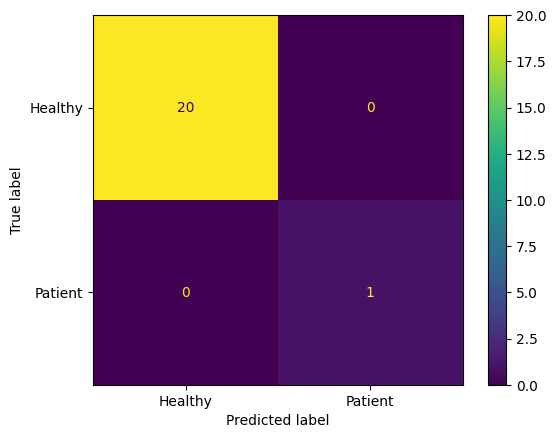

In [ ]:
display_confusionMatrix(y_true,y_pred)

### densenet121

In [ ]:
y_true, y_pred = predict(model_densenet121 , resolution2_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.12      1.00      0.22         1

    accuracy                           0.67        21
   macro avg       0.56      0.82      0.51        21
weighted avg       0.96      0.67      0.76        21



In [ ]:
densenet121_resolution2 = accuracy_score(y_true, y_pred)
densenet121_resolution2

0.6666666666666666

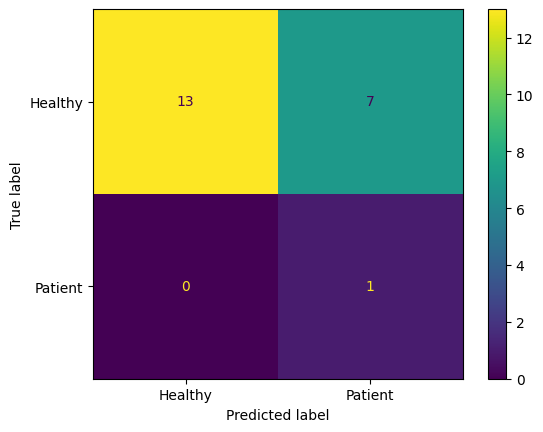

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.12      1.00      0.22         1

    accuracy                           0.67        21
   macro avg       0.56      0.82      0.51        21
weighted avg       0.96      0.67      0.76        21



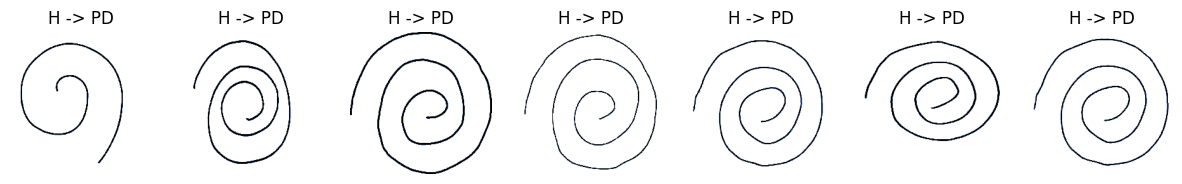

In [ ]:
display_wrong_output(model_densenet121, resolution2_loader)

### densenet201

In [ ]:
y_true, y_pred = predict(model_densenet201 , resolution2_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.25      1.00      0.40         1

    accuracy                           0.86        21
   macro avg       0.62      0.93      0.66        21
weighted avg       0.96      0.86      0.89        21



In [ ]:
densenet201_resolution2 = accuracy_score(y_true, y_pred)
densenet201_resolution2

0.8571428571428571

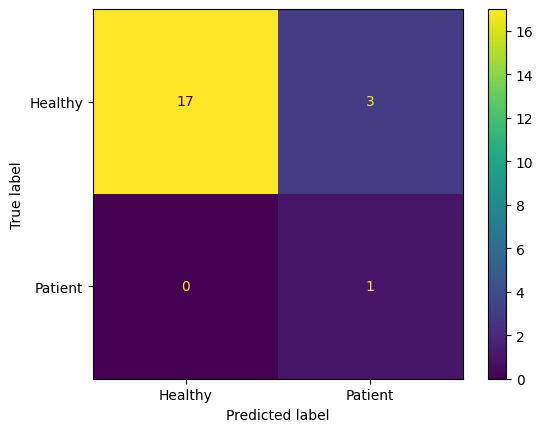

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.25      1.00      0.40         1

    accuracy                           0.86        21
   macro avg       0.62      0.93      0.66        21
weighted avg       0.96      0.86      0.89        21



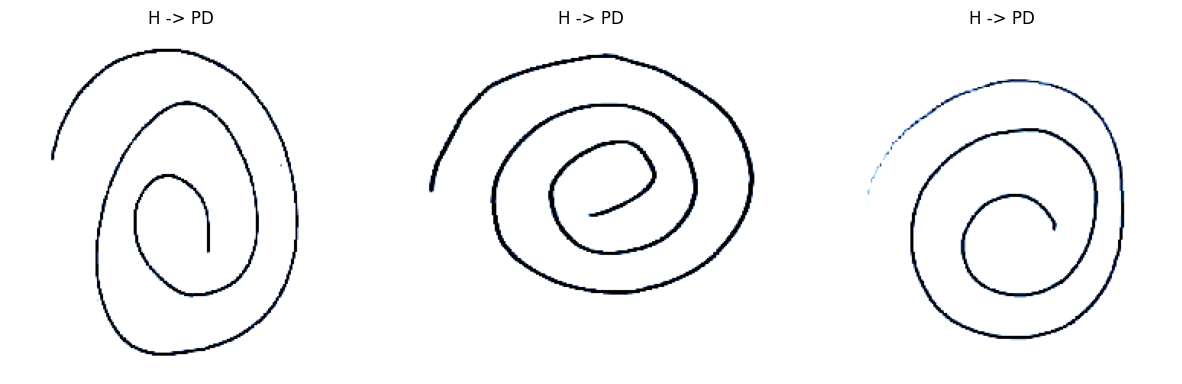

In [ ]:
display_wrong_output(model_densenet201, resolution2_loader)

### vgg16

In [ ]:
y_true, y_pred = predict(model_vgg16 , resolution2_loader)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         1

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [ ]:
vgg16_resolution2 = accuracy_score(y_true, y_pred)
vgg16_resolution2

1.0

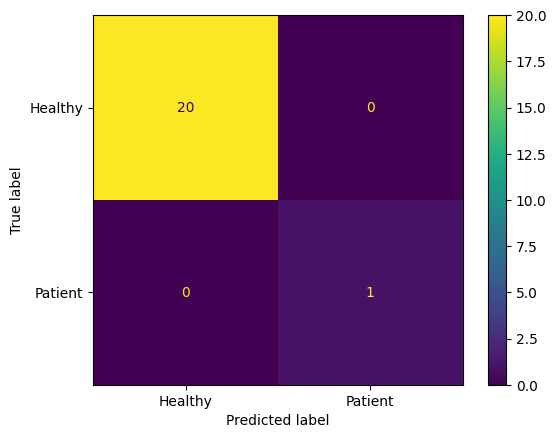

In [ ]:
display_confusionMatrix(y_true,y_pred)

True


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



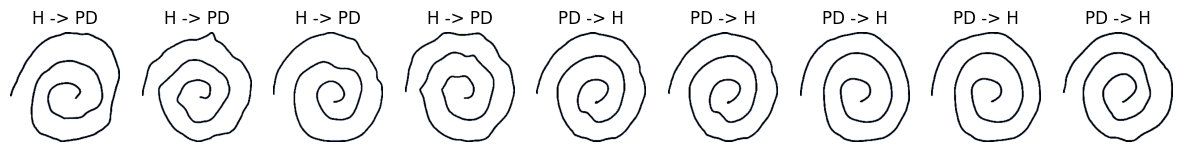

In [ ]:
display_wrong_output(model_vgg16 , resolution_loader)

# Compare

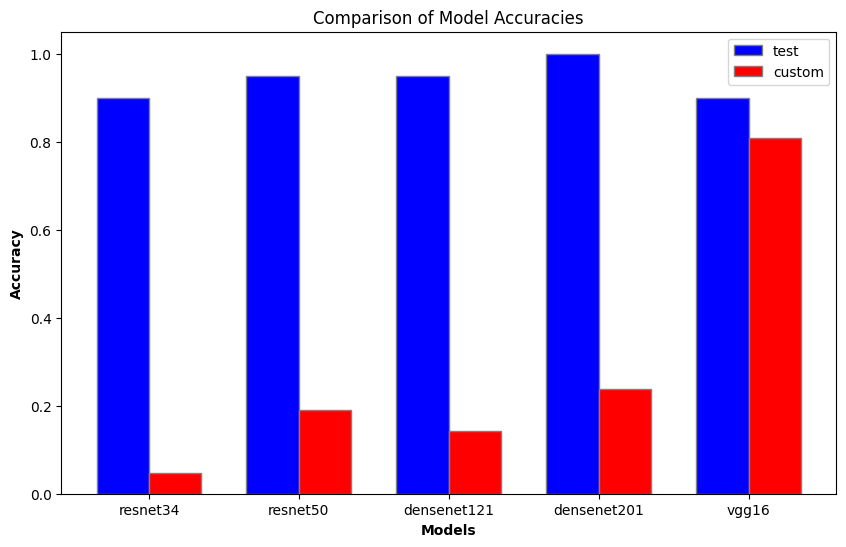

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
accuracy2 = [resnet34_custom, resnet50_custom, densenet121_custom, densenet201_custom, vgg16_custom]

# Setting the bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy1, color='b', width=bar_width, edgecolor='grey', label='test')
plt.bar(r2, accuracy2, color='r', width=bar_width, edgecolor='grey', label='custom')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Show the plot
plt.show()


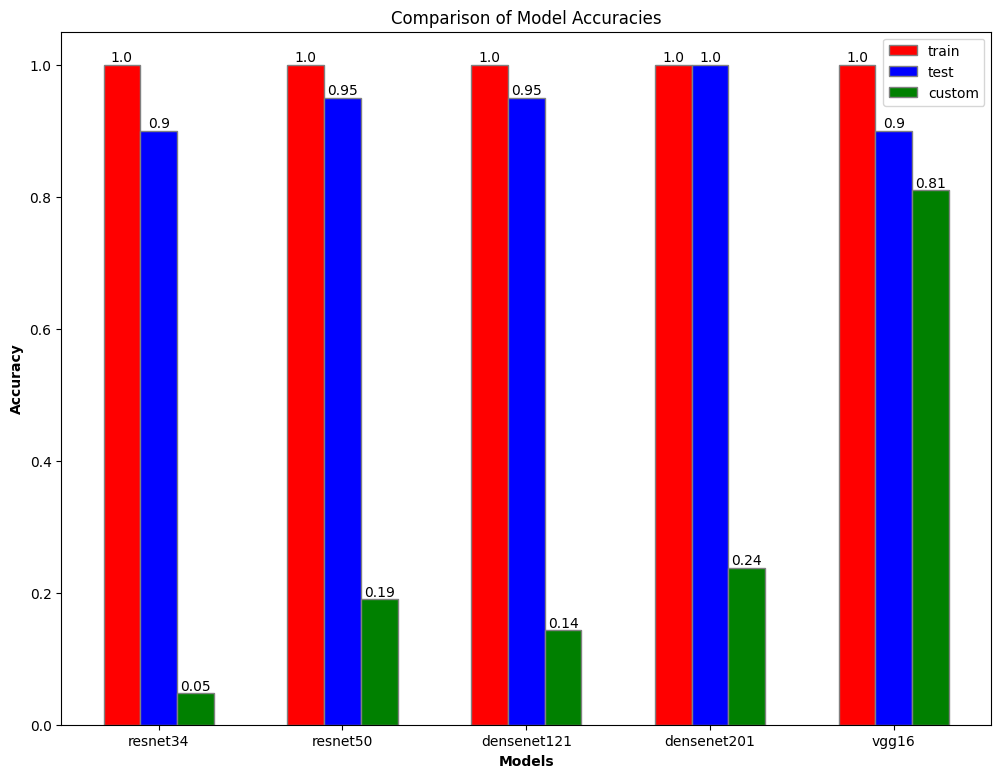

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_train, resnet50_train, densenet121_train, densenet201_train, vgg16_train]
accuracy2 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
accuracy3 = [resnet34_custom, resnet50_custom, densenet121_custom, densenet201_custom, vgg16_custom]

bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(12, 9))
bars1 = plt.bar(r1, accuracy1, color='r', width=bar_width, edgecolor='grey', label='train')
bars2 = plt.bar(r2, accuracy2, color='b', width=bar_width, edgecolor='grey', label='test')
bars3 = plt.bar(r3, accuracy3, color='g', width=bar_width, edgecolor='grey', label='custom')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

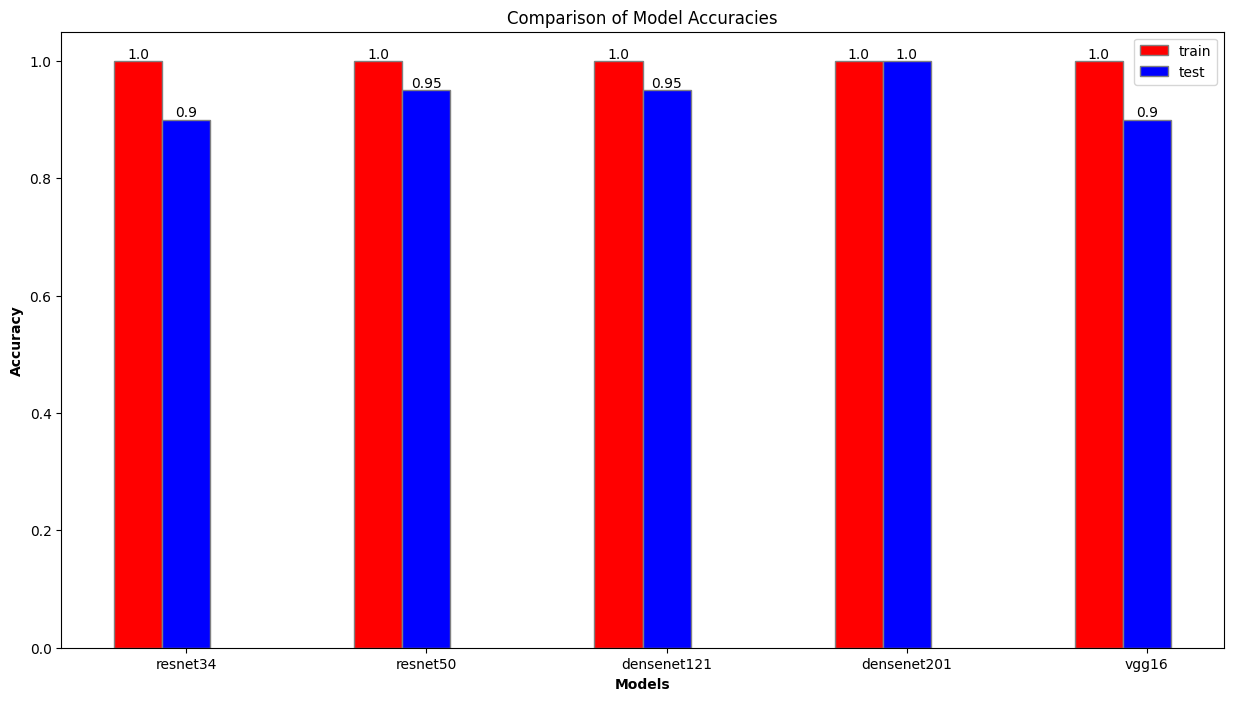

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_train, resnet50_train, densenet121_train, densenet201_train, vgg16_train]
accuracy2 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(15, 8))
bars1 = plt.bar(r1, accuracy1, color='r', width=bar_width, edgecolor='grey', label='train')
bars2 = plt.bar(r2, accuracy2, color='b', width=bar_width, edgecolor='grey', label='test')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

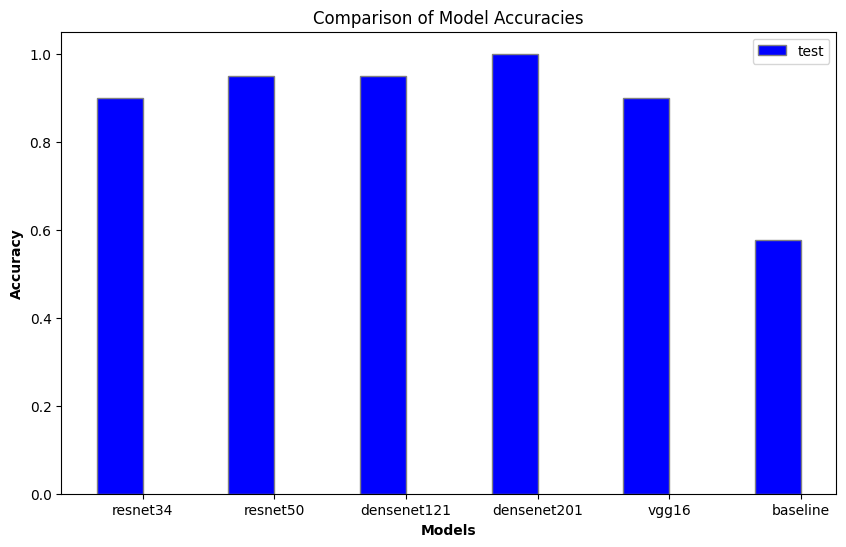

In [50]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16','baseline']
accuracy1 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test,11.54/20]

# Setting the bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy1, color='b', width=bar_width, edgecolor='grey', label='test')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()



# Show the plot
plt.show()


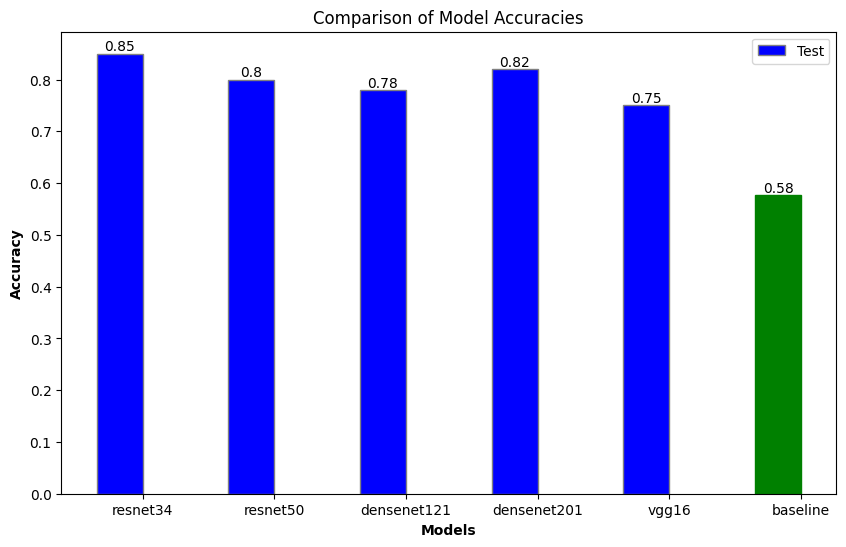

In [53]:

# Example accuracy values for six models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16', 'baseline']
accuracy1 = [0.85, 0.80, 0.78, 0.82, 0.75, 11.54/20]  # Replace with your actual accuracy values

# Setting the bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))

# Create the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(r1, accuracy1, color='b', width=bar_width, edgecolor='grey', label='Test')

# Change the color of the rightmost bar
bars1[-1].set_color('g')  # You can choose any color you like, here it's set to green ('g')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()


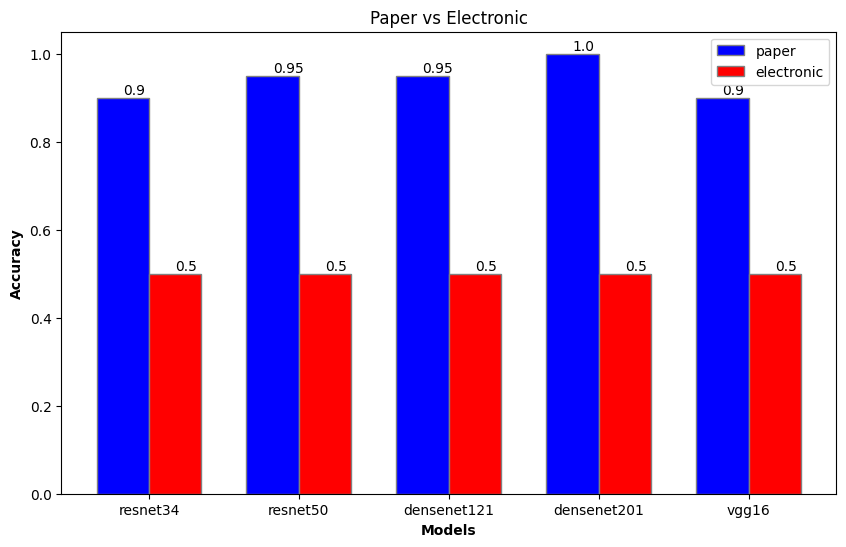

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
accuracy2 = [resnet34_elec, resnet50_elec, densenet121_elec, densenet201_elec, vgg16_elec]

# Setting the bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(r1, accuracy1, color='b', width=bar_width, edgecolor='grey', label='paper')
bars2 = plt.bar(r2, accuracy2, color='r', width=bar_width, edgecolor='grey', label='electronic')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Add title and legend
plt.title('Paper vs Electronic')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Show the plot
plt.show()


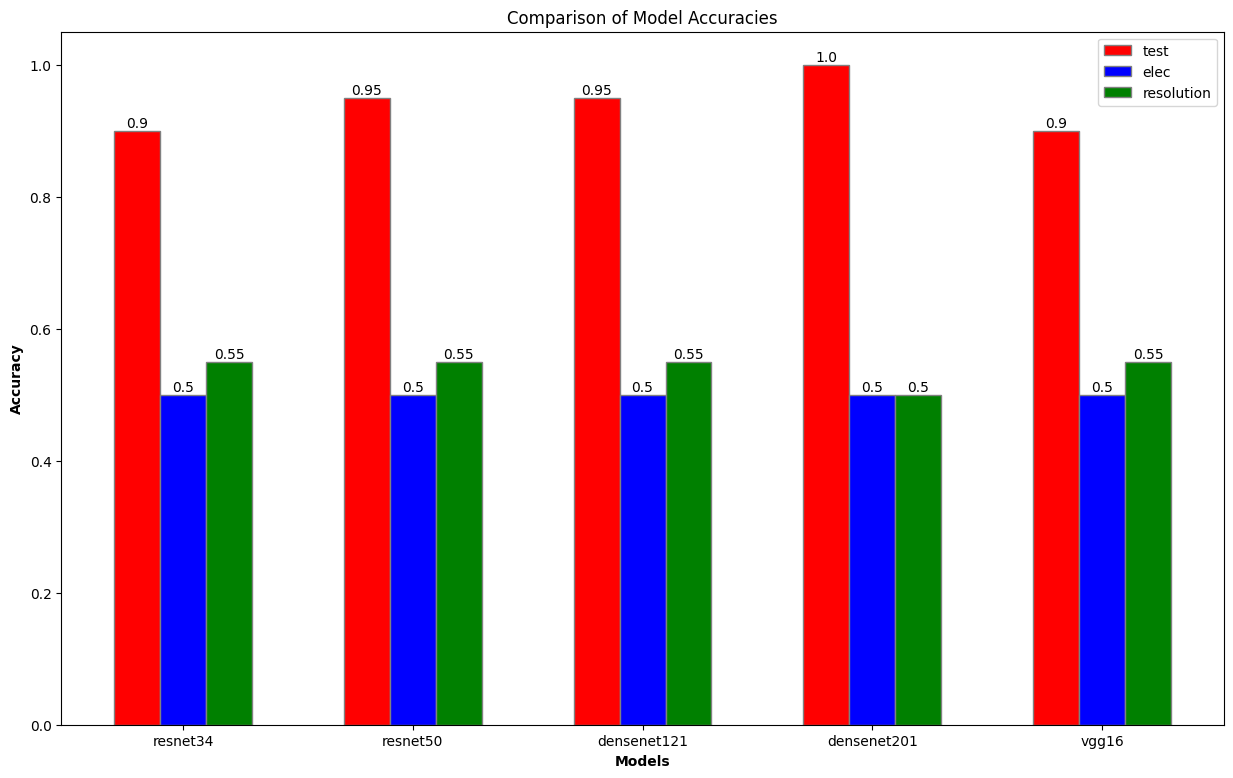

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
accuracy2 = [resnet34_elec, resnet50_elec, densenet121_elec, densenet201_elec, vgg16_elec]
accuracy3 = [resnet34_resolution, resnet50_resolution, densenet121_resolution, densenet201_resolution, vgg16_resolution]

bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(15, 9))
bars1 = plt.bar(r1, accuracy1, color='r', width=bar_width, edgecolor='grey', label='test')
bars2 = plt.bar(r2, accuracy2, color='b', width=bar_width, edgecolor='grey', label='elec')
bars3 = plt.bar(r3, accuracy3, color='g', width=bar_width, edgecolor='grey', label='resolution')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

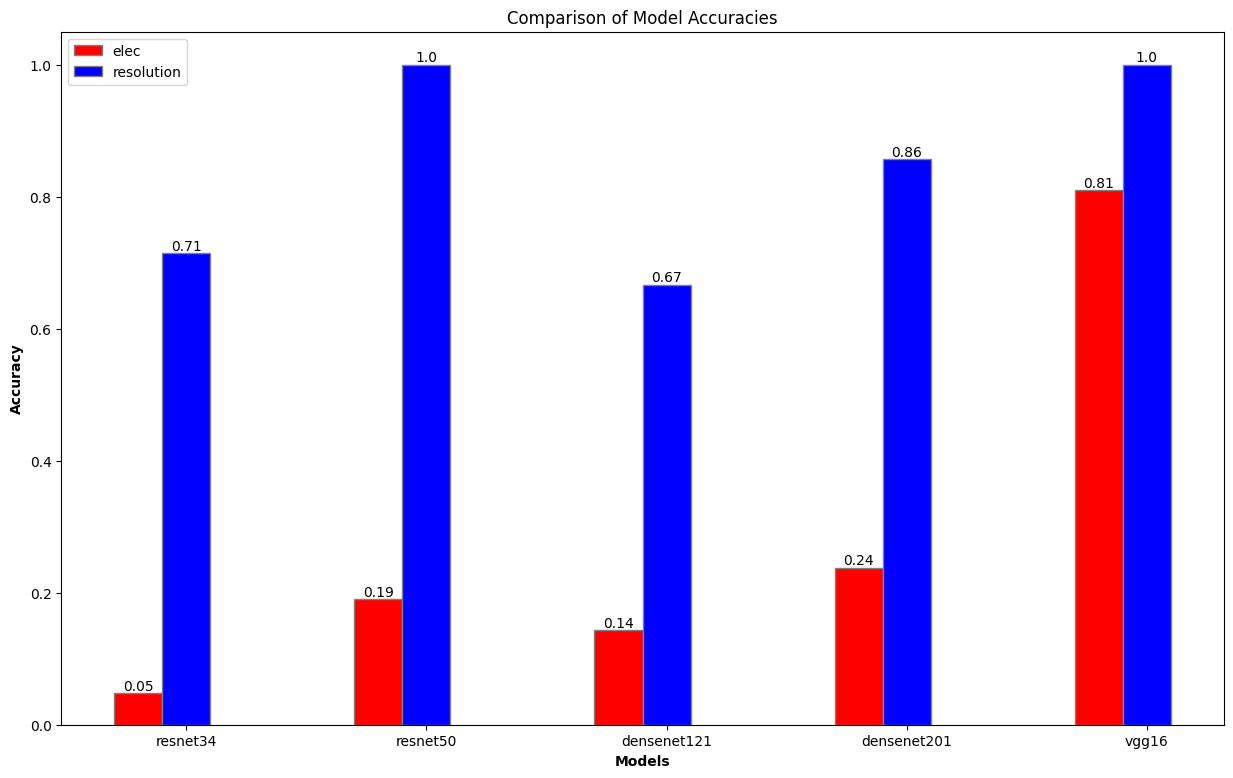

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']
accuracy1 = [resnet34_custom, resnet50_custom, densenet121_custom, densenet201_custom, vgg16_custom]
accuracy2 = [resnet34_resolution2, resnet50_resolution2, densenet121_resolution2, densenet201_resolution2, vgg16_resolution2]

bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(15, 9))
bars1 = plt.bar(r1, accuracy1, color='r', width=bar_width, edgecolor='grey', label='elec')
bars2 = plt.bar(r2, accuracy2, color='b', width=bar_width, edgecolor='grey', label='resolution')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()

# Display the value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), ha='center', va='bottom')


# Show the plot
plt.show()

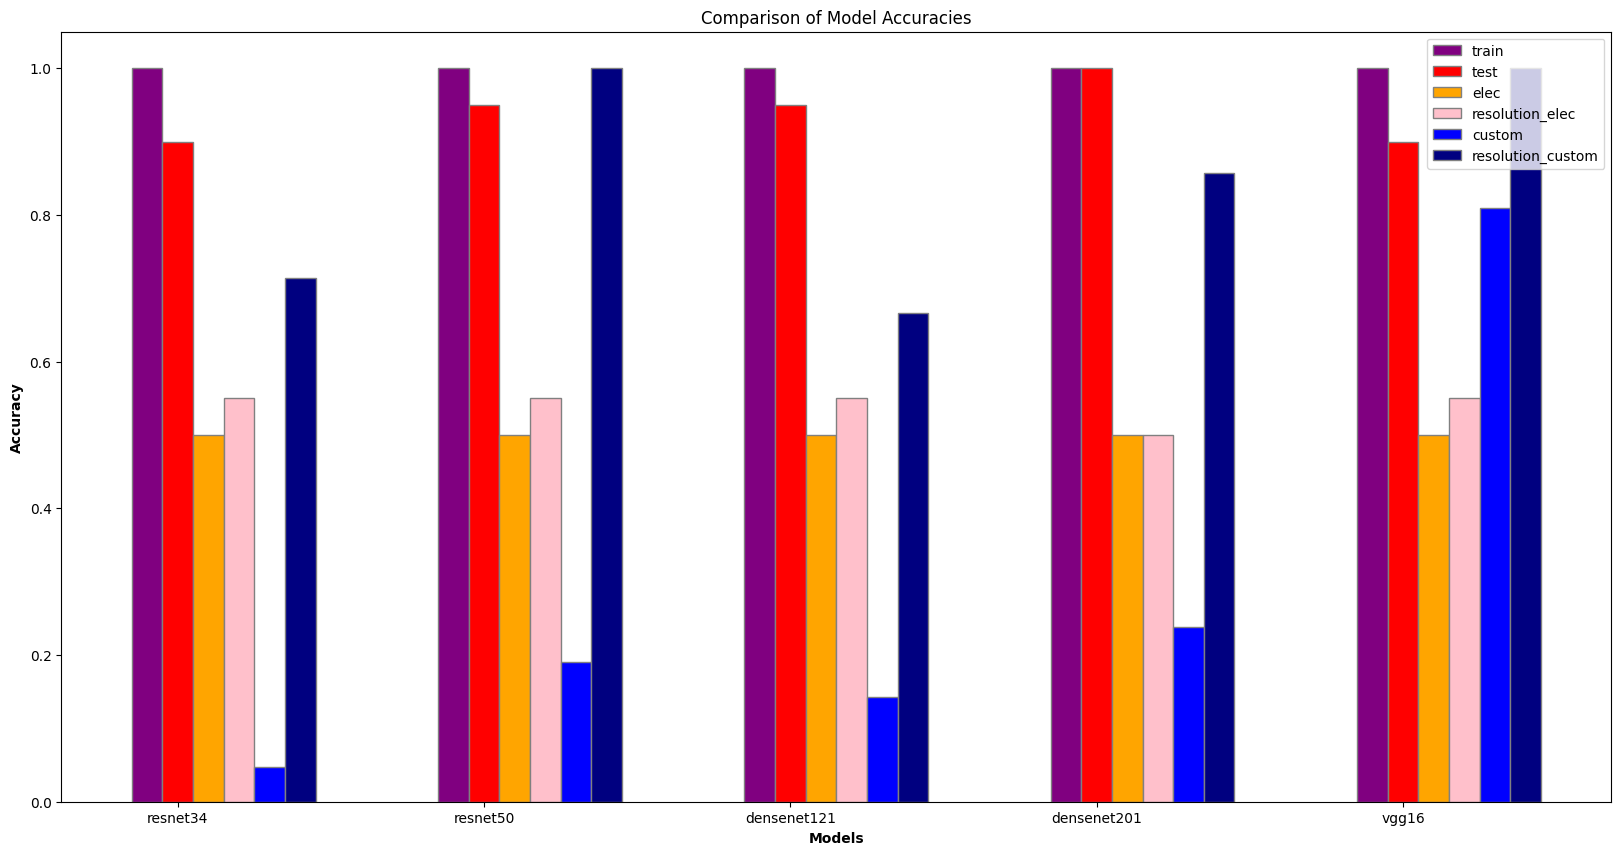

In [ ]:
# Example accuracy values for four models (replace these with your actual values)
models = ['resnet34', 'resnet50', 'densenet121', 'densenet201', 'vgg16']

accuracy1 = [resnet34_train, resnet50_train, densenet121_train, densenet201_train, vgg16_train]

accuracy2 = [resnet34_test, resnet50_test, densenet121_test, densenet201_test, vgg16_test]
accuracy3 = [resnet34_elec, resnet50_elec, densenet121_elec, densenet201_elec, vgg16_elec]
accuracy4 = [resnet34_resolution, resnet50_resolution, densenet121_resolution, densenet201_resolution, vgg16_resolution]

accuracy5 = [resnet34_custom, resnet50_custom, densenet121_custom, densenet201_custom, vgg16_custom]
accuracy6 = [resnet34_resolution2, resnet50_resolution2, densenet121_resolution2, densenet201_resolution2, vgg16_resolution2]

bar_width = 0.1

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Create the bar chart
plt.figure(figsize=(20, 10))
bars1 = plt.bar(r1, accuracy1, color='purple', width=bar_width, edgecolor='grey', label='train')

bars2 = plt.bar(r2, accuracy2, color='red', width=bar_width, edgecolor='grey', label='test')
bars3 = plt.bar(r3, accuracy3, color='orange', width=bar_width, edgecolor='grey', label='elec')
bars4 = plt.bar(r4, accuracy4, color='pink', width=bar_width, edgecolor='grey', label='resolution_elec')

bars5 = plt.bar(r5, accuracy5, color='blue', width=bar_width, edgecolor='grey', label='custom')
bars6 = plt.bar(r6, accuracy6, color='navy', width=bar_width, edgecolor='grey', label='resolution_custom')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add title and legend
plt.title('Comparison of Model Accuracies')
plt.legend()


# Show the plot
plt.show()